In [171]:
import torch
torch.cuda.is_available()

True

# Introduction

In this notebook, we walk through the spuriosity rankings method and apply it on a gender classification task using UTKFace data.

Spuriosity Rankings is a framework for understanding the complexities that exist within a dataset, towards efficiently uncovering, measuring, and mitigating biases (i.e. performance disparities). 

Thus, the only input you need is a classification dataset. Our framework utilizes an auxiliary model to discover salient concepts for each class, allowing for a human in the loop to flag concepts that they do not want their model to rely upon; thus, you have the power to define 'spurious' as you please! Then, we sort data along these directions, so to extract examples that break the spurious correlations (i.e. low spuriosity images). Finally, mitigating the biases is as simple as finetuning the classification on the low spuriosity images. 

In step 1, we initialize the dataset we will use to demonstrate our method: UTKFace, for gender classfication. In step 2, we demonstrate feature discovery. In step 3, we show how we can sort data to efficiently measure and mitigate biases. Finally, we show how the entire pipeline can be run by calling just two functions. 

In [192]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
%reload_ext autoreload

In [178]:
from spuriosity_rankings import compute_features, fit_head, cache_data, load_cached_data, Accuracy, SpuriousGap, \
    load_robust_encoder, find_important_ftrs, visualize_ftr, measure_bias
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import os
import torch
import numpy as np

And some imports for prettier plots.

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_theme(style="darkgrid")
sns.use_tex = True
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": "cmss10",
    "axes.formatter.use_mathtext": "True"
})

# Step 1: Initialize datasets

Spuriosity-rankings allows you to sort your own data along potential directions of bias. Thus, the most important input to our pipeline is the dataset. You will create a dataset object for the train and validation splits your data. 

We do so for the gender classification task on UTKFace data below. 

In [ ]:
from datasets import UTKFace
transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])
train_dset, val_dset = [UTKFace(target='gender', split=s, transform=transform) for s in ['train', 'test']]
dsetname = 'UTKFace_gender'

# Step 2: Discovering salient features via auxiliary interpretable model + data sorting + XAI

To efficiently sort data along directions of interest, we fit a linear classifier over interpretable (i.e. adversarially trained) neural feature encodings of your data. We can then automatically identify which neural features encode salient concepts for your task. Then, we can uncover the conept encoded by the neural feature using 
1. the most (and least) activating images per feature 
2. neural activation maps 
3. feature attacks

Note that we discover salient features *per class*.

## 2a. Encode data using an adversarially robust encoder

In [181]:
_RESULTS_ROOT = './'
dset_results_root = os.path.join(_RESULTS_ROOT, dsetname)
os.makedirs(dset_results_root, exist_ok=True)

print("\n\nLoading interpretable feature encoder.")
encoder = load_robust_encoder()

print("\n\nEncoding images.")
ftrs_dict, labels_dict = dict(), dict()
for split, dset in zip(['train', 'val'], [train_dset, val_dset]):
    loader = torch.utils.data.DataLoader(dset, shuffle=False, num_workers=4, batch_size=32)
    ftrs, labels = compute_features(encoder, loader, os.path.join(dset_results_root, f"{split}_ftrs.pkl"))
    ftrs_dict[split] = ftrs
    labels_dict[split] = labels



Loading interpretable feature encoder.


Encoding images.


## Step 2b. Extract salient robust neural features per class

Here we fit our linear layer on the robust neural features, and use the weights of this layer (and cached embeddings) to identify which neural features contribute the most to each class logit.

In [182]:
most_important_ftrs_path = os.path.join(dset_results_root, 'most_important_ftrs.pkl')
predictions_path = os.path.join(dset_results_root, 'predictions.pkl')
lin_head_path = os.path.join(dset_results_root, 'lin_head_data.pkl')
if not os.path.exists(lin_head_path):
    print("\n\nTraining linear layer on encoded features.")
    eval_fn = Accuracy()
    head, acc = fit_head(ftrs_dict, labels_dict, verbose=True)
    print(f'\nLinear layer trained. Accuracy: {acc:.2f}%.')
    print("\n\nExtracting salient features.")

    most_important_ftrs, preds = find_important_ftrs(ftrs_dict['train'], labels_dict['train'], head)
    cache_data(most_important_ftrs_path, most_important_ftrs)
    cache_data(predictions_path, preds)
    
    head_data = dict({'state': head.state_dict(), 'val_acc': acc, 'shape': head.weight.shape})
    cache_data(head_data, head_save_path)
else: 
    print("\n\nUsing cached important features, predictions, and linear head.")
    most_important_ftrs = load_cached_data(most_important_ftrs_path)
    preds = load_cached_data(predictions_path)

    head_data = load_cached_data(lin_head_path)
    head = torch.nn.Linear(in_features=head_data['shape'][1], out_features=head_data['shape'][0], bias=True)
    head.load_state_dict(head_data['state'])




Using cached important features, predictions, and linear head.


### Step 2c. Measure and visualize potential biases

We can then sort data along each salient neural feature, and take a closer look at the features that result in performance disparities. Below we inspect the top 15 most important features per class. Since we set min_gap to 0, we save visualizations for all features per class, though we can change this parameter in order to focus only on features where accuracy changes by at least 10% between most and least activating images. 

In [10]:
num_ftrs_per_class = 15
min_gap = 0

grids = dict()

for cls_ind in most_important_ftrs:
    classname = train_dset.classes[cls_ind].title().replace(" ","")
    grids[classname] = dict()
    cls_save_root = os.path.join(dset_results_root, 'ftr_viz', f'class_{cls_ind}_{classname}')
    os.makedirs(cls_save_root, exist_ok=True)
    in_cls_idx = np.where(labels_dict['train'] == cls_ind)[0]
    class_acc = (preds[in_cls_idx] == cls_ind).mean().item()*100
    print(f"\n\nProcessing {train_dset.classes[cls_ind]} class. Overall accuracy for class: {class_acc:.2f}%")
    for ftr_rank in tqdm(range(num_ftrs_per_class)):
        ftr_ind = most_important_ftrs[cls_ind][ftr_rank]
        save_path = os.path.join(cls_save_root, f"rank_{ftr_rank}_ftr_{ftr_ind}.jpg")
        grid = visualize_ftr(cls_ind, ftr_ind, ftrs_dict['train'], labels_dict['train'], 
                        train_dset, encoder, save_path, preds=preds, min_gap=min_gap)
        grids[classname][ftr_ind] = grid



Processing Male class. Overall accuracy for class: 87.87%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:02<00:00,  8.14s/it]




Processing Female class. Overall accuracy for class: 89.95%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:10<00:00,  8.70s/it]


These visualizations are all saved to a sub-directory of `dset_results_root`, which for this demo is `outputs/utkface_gender/ftr_viz/`. Let's take a look at a couple of those visualizations here. 

The rows in each visualization are as follows: 
1. Top activating images
2. Neural activation maps for the top images
3. Feature attacks for the top iamges
4. Least activating images

Notice that the feature is not present in the least activating images.

In [183]:
cool_ftrs = dict({
    (0, 'Male'): [(1108, 'Suit & Tie 1'), (190, 'Hands')],
    (1, 'Female'): [(1016, 'Fair skin'), (333, 'Long brown hair')]})

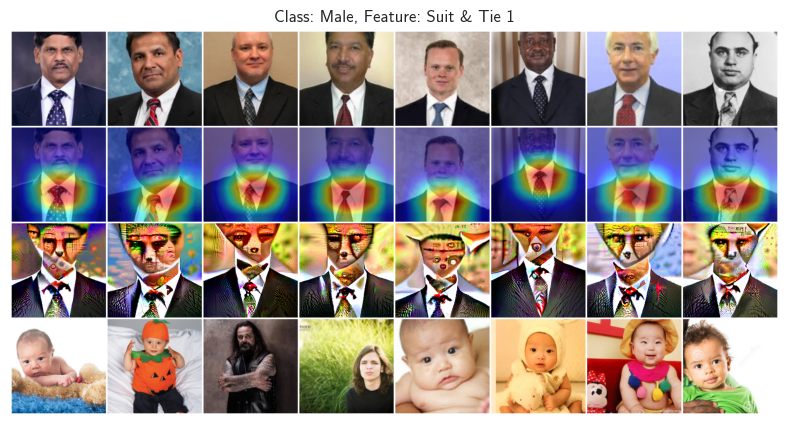

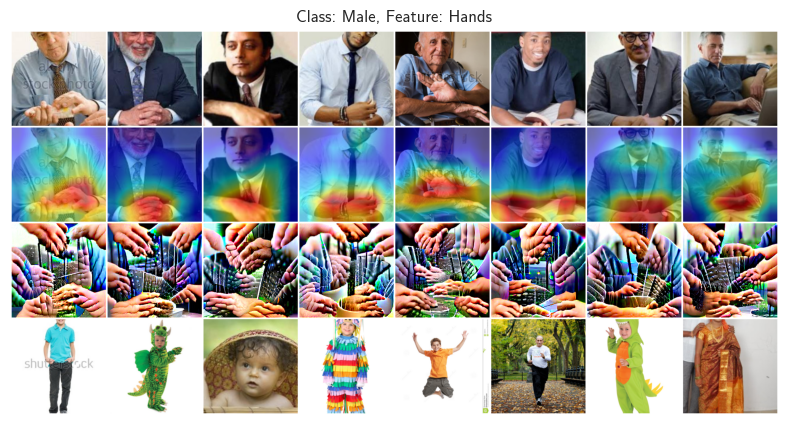

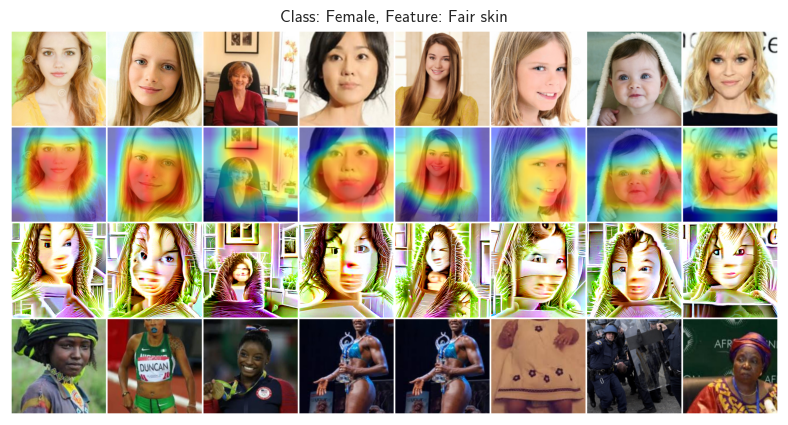

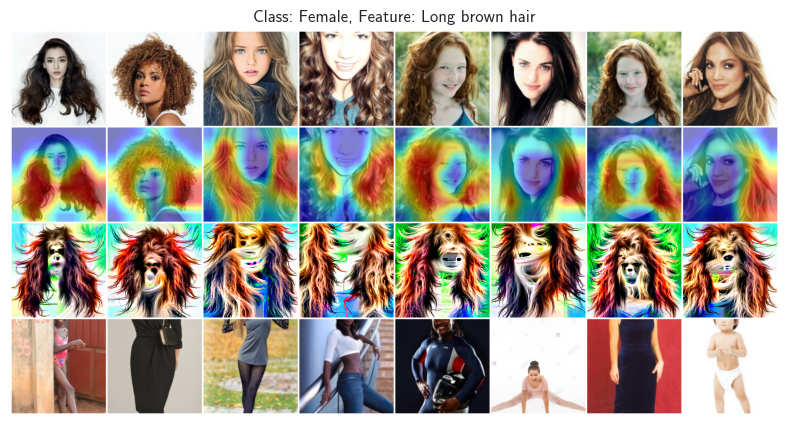

In [184]:
to_pil = transforms.ToPILImage()

for (cls_ind, classname), ftr_idx_and_names in cool_ftrs.items():
    for ftr_ind, ftr_name in ftr_idx_and_names:
        f, ax = plt.subplots(1, 1, figsize=(15,5))
        im = to_pil(grids[classname][ftr_ind])
        ax.imshow(im)
        ax.set_axis_off()
        ax.set_title(f"Class: {classname}, Feature: {ftr_name}")
        f.show()

# Step 3: Measure and Mitigate Biases

## Step 3a: Measuring biases

Measuring bias along any of these directions is as easy as taking the difference in accuracy across most and least activating images. Let's check the bias for each of the previously (manually) identified 'cool' features now.

Note that we are reusing the lightweight model used to identify features (consisting of a frozen adversarially trained feature encoder + trained linear layer). However, we can measure bias for any model that performs our task. All you need to do is change the `preds` argument.

In [185]:
def biases_for_cool_ftrs(preds=preds, k=100, verbose=False):
    biases = dict()
    for (cls_ind, classname), ftr_info in cool_ftrs.items():
        for (ftr_ind, ftr_name) in ftr_info:
            gap,_,_ = measure_bias(cls_ind, ftr_ind, ftrs_dict['train'], labels_dict['train'], preds, k=k)
            biases[(classname, ftr_name)] = gap
            if verbose:
                print(f"Class: {classname:<10}, Feature: {ftr_name:<15}, Accuracy gap: {gap:.2f}%")
    return biases

og_biases = biases_for_cool_ftrs(preds, verbose=True)

Class: Male      , Feature: Suit & Tie 1   , Accuracy gap: 33.00%
Class: Male      , Feature: Hands          , Accuracy gap: 25.00%
Class: Female    , Feature: Fair skin      , Accuracy gap: 49.00%
Class: Female    , Feature: Long brown hair, Accuracy gap: 38.00%


## Step 3b: Mitigating Biases

After having a human in the loop inspect the potential biases, we can now efficiently mitigate biases deemed problematic. Namely, we aggregate rankings per-bias to get a single set of rankings per class. Namely, we average the z-scores of activations per bias (i.e. robust neural feature), and use this to rank images within their class. 

In [186]:
def sort_data(ftrs_dict, labels_dict, spurious_ftrs_by_cls):

    # We obtain a ranking per class, tho we only really care about the top and bot idx
    bot_idx, top_idx = [dict({s:dict() for s in ['train', 'val']}) for _ in range(2)]
    for split in ['train', 'val']:
        ftrs, labels = [d[split] for d in [ftrs_dict, labels_dict]]
        for cls_ind, spur_ftrs in spurious_ftrs_by_cls.items():
            zscores = []
            cls_idx = np.where(labels == cls_ind)[0]
            for ftr_ind in spur_ftrs:
                vals = ftrs[cls_idx, ftr_ind]
                mean, std = vals.mean(), vals.std()
                zscores.append((vals - mean) / std)
            
            avg_zscores = np.array(zscores).mean(0)
            sorted_idx = np.argsort(avg_zscores)
            bot_idx[split][cls_ind] = cls_idx[sorted_idx[:1000]]
            top_idx[split][cls_ind] = cls_idx[sorted_idx[-1000:]]

    return bot_idx, top_idx

Let's just take the few biases highlighted above in the cool_ftrs dictionary. We'll reformat that to obtain a spurious_ftrs_by_cls dictionary, which has key-value pairs of (class index, list of feature indices encoding biases we want to mitigate).

In [187]:
spurious_ftrs_by_cls = dict({
    cls_ind: [ftr_ind for (ftr_ind, ftr_name) in ftr_info]
    for (cls_ind, cls_name), ftr_info in cool_ftrs.items()
})

Now we call sort_data, to obtain our spuriosity rankings, given the identified 'spurious' features. Note that ***the definition of spurious here is completely up to you***. That is, our method allows a human in the loop to see what kind of biases may emerge, and choose which ones they wish to mitigate. You have the power!

In [188]:
bot_idx, top_idx = sort_data(ftrs_dict, labels_dict, spurious_ftrs_by_cls)

Let's take a peek at some of the 'low spuriosity' images for the female class using our aggregated rankings. We see lots of short haired women, many of which do not have fair skin. These images essentially break the spurious correlations that our model was biased to.

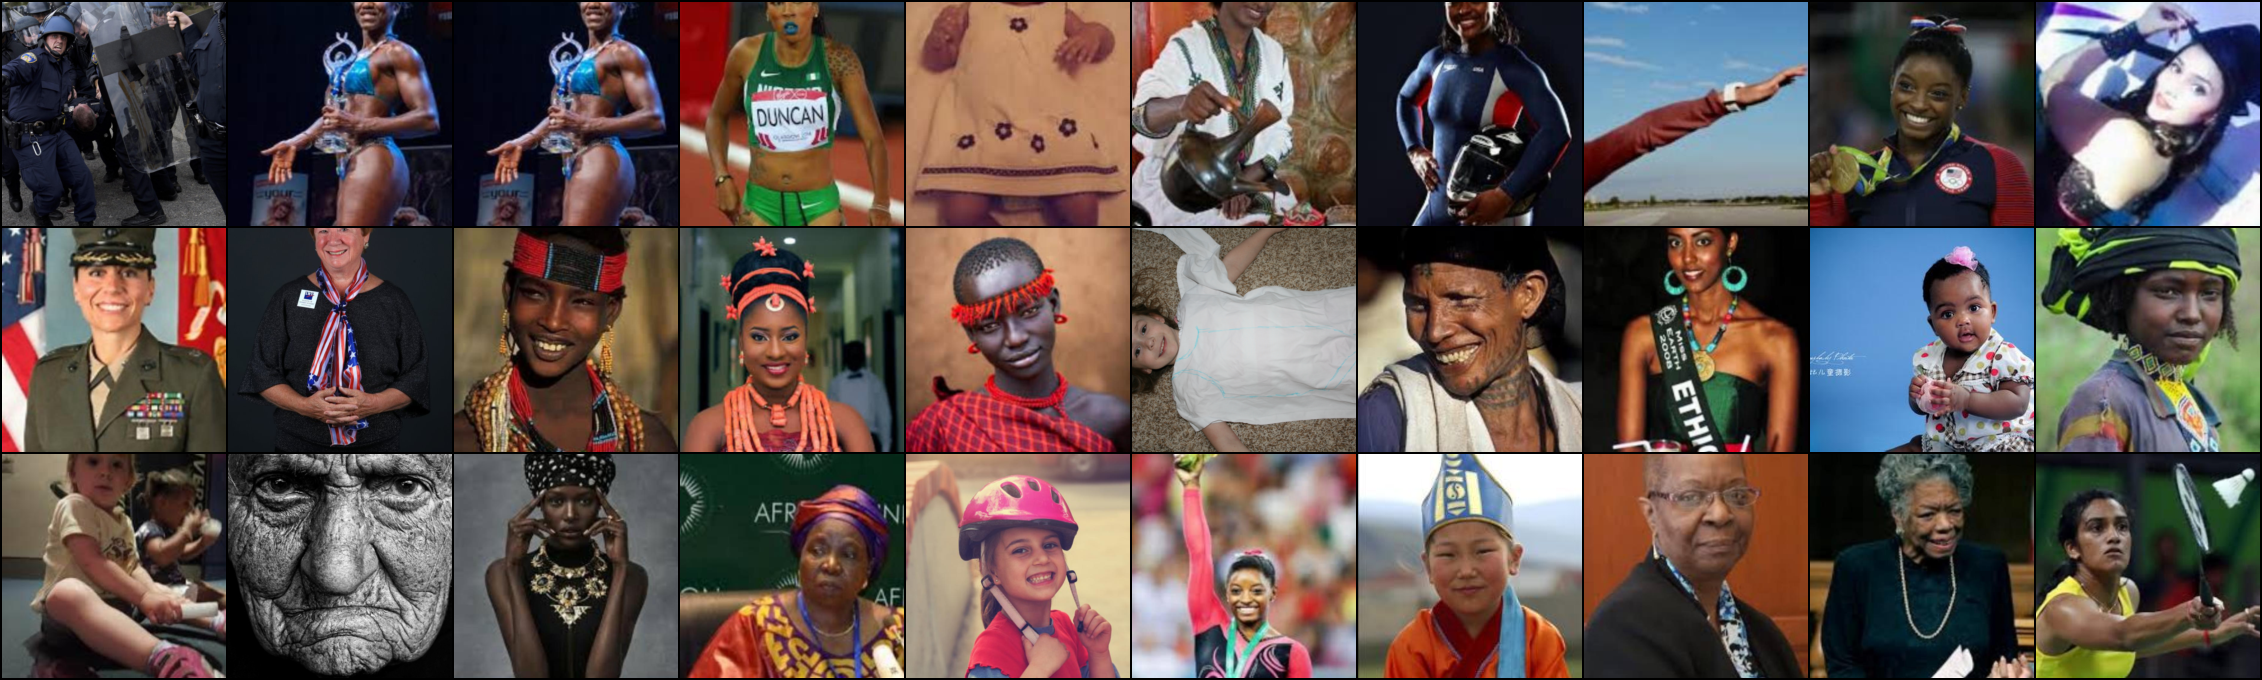

In [189]:
bot_imgs = [train_dset[i][0] for i in bot_idx['train'][1][:30]]
grid = make_grid(bot_imgs, nrow=10)
to_pil(grid)

Now, we will set up an object to evaluate the spurious gap on validation data, and also update the training set to only include low spuriosity images.

Specifically, we collapse the output of the previous function to get a list of sample indices across all classes for all high and low spuriosity images. To compute spuriosity gap, 

In [133]:
low_spur_idx, high_spur_idx = [dict({split:[] for split in ['train', 'val']}) for _ in range(2)]
ks= 100
for split in ['train', 'val']:
    for cls_ind in spurious_ftrs_by_cls:
        low_spur_idx[split].extend(bot_idx[split][cls_ind][:k])
        high_spur_idx[split].extend(top_idx[split][cls_ind][:k])

spurious_gap_eval_fn = SpuriousGap(low_spur_idx['val'], high_spur_idx['val'])


new_ftrs_dict, new_labels_dict = [
    dict({
        'train': d['train'][low_spur_idx['train']],
        'val': d['val']
    }) for d in [ftrs_dict, labels_dict]
]

And before we tune the classificaton head, let's see what spurious gap we get for our original model (note that again, we are reusing the model we used for feature discovery, but any classification model would work here; you would just need to pass it's classification head, along with cached features using that model's encoder). 

In [134]:
spurious_gap_eval_fn.metric(head.cuda(), new_ftrs_dict['val'], new_labels_dict['val'])

16.5

In [165]:
accuracy = Accuracy()
accuracy.metric(head.cuda(), new_ftrs_dict['val'], new_labels_dict['val'])

87.4265038444143

Ok, now let's close that spurious gap! We can choose how low we want to bring the spurious gap too. In the paper, we used a stop threshold (the second entry of the close_spurious_gap_info tuple) of 5 for ImageNet. Choosing a lower value may result in a larger drop in overall validation accuracy. Let's try a stop threshold of 1, meaning we tune on low spuriosity images until the spuriosity gap (measured on validation images) drops below 1%. Then, we stop our tuning early, so to not overfit on the low spuriosity images.

In [163]:
close_spurious_gap_info = (spurious_gap_eval_fn, 2.5)
import time
start = time.time()
new_head, new_acc = fit_head(new_ftrs_dict, new_labels_dict, close_spurious_gap_info, init_head=head, verbose=True, lr=0.001)
end = time.time() - start
print(f'Time elapsed: {end:.2f} seconds')

Epoch:   1/ 20, Training Accuracy: 54.50%, Validation Accuracy: 87.34%, Spurious gap: 16.50%
Epoch:   2/ 20, Training Accuracy: 55.00%, Validation Accuracy: 87.47%, Spurious gap: 14.50%
Epoch:   3/ 20, Training Accuracy: 58.00%, Validation Accuracy: 87.47%, Spurious gap: 8.00%
Epoch:   4/ 20, Training Accuracy: 61.50%, Validation Accuracy: 87.06%, Spurious gap: 8.50%
Epoch:   5/ 20, Training Accuracy: 63.50%, Validation Accuracy: 87.06%, Spurious gap: 6.00%
Epoch:   6/ 20, Training Accuracy: 66.50%, Validation Accuracy: 86.43%, Spurious gap: 6.00%
Epoch:   7/ 20, Training Accuracy: 68.50%, Validation Accuracy: 86.30%, Spurious gap: 4.00%
Epoch:   8/ 20, Training Accuracy: 73.00%, Validation Accuracy: 85.98%, Spurious gap: 0.50%
Time elapsed: 0.28 seconds


So in less than a second, we could reduce our overall spurios gap from 16.5% to 0.5%, while losing less than 1.5% overall validation accuracy. Let's take a look at the improvement per bias as well. 

In [164]:
new_preds = new_head(torch.tensor(ftrs_dict['train']).cuda()).argmax(1).detach().cpu().numpy()
new_biases = biases_for_cool_ftrs(preds=new_preds, verbose=True)

Class: Male      , Feature: Suit & Tie 1   , Accuracy gap: 20.00%
Class: Male      , Feature: Hands          , Accuracy gap: 10.00%
Class: Female    , Feature: Fair skin      , Accuracy gap: 23.00%
Class: Female    , Feature: Long brown hair, Accuracy gap: 30.00%


That yields the following improvements per bias:

In [169]:
gains = []
for bias in new_biases:
    og_bias, new_bias = [d[bias] for d in [og_biases, new_biases]]
    cls_name, ftr_name = bias
    print(f"Class: {cls_name:<10} Feature: {ftr_name:<20} Original Bias: {og_bias:.2f}% New Bias: {new_bias:.2f}% Improvement: {og_bias - new_bias:.2f}%")
    gains.append(og_bias - new_bias)
print(f'On average, the highlighted biases are reduced by {np.average(gains):.2f}%.')

Class: Male       Feature: Suit & Tie 1         Original Bias: 33.00% New Bias: 20.00% Improvement: 13.00%
Class: Male       Feature: Hands                Original Bias: 25.00% New Bias: 10.00% Improvement: 15.00%
Class: Female     Feature: Fair skin            Original Bias: 49.00% New Bias: 23.00% Improvement: 26.00%
Class: Female     Feature: Long brown hair      Original Bias: 38.00% New Bias: 30.00% Improvement: 8.00%
On average, the highlighted biases are reduced by 15.50%.


This concludes our demo! We have shown how Spuriosity rankings allows for uncovering hidden subgroups within one's dataset, as well as measuring and mitigating biases obscured by overall accuracy. In a matter of minutes, we can better understand a dataset, and fix potential biases at little cost to overall accuracy. 

# Running the pipeline with just two function calls

The above demo is intended to allow for greater understanding of how our method works. If speed is preferred, you can also run the whole pipeline in far fewer lines of code, shown below. 

Note that we utilize a human in the loop, so after feature discovery, one would still need to inspect the highlighted features and manually enter the `spurious_ftrs_by_cls` dictionary. Then, we can measure and mitiagte biases (due to the selected spurious correlations) with one additional function call. 

In [196]:
from spuriosity_rankings import ftr_discovery, mitigate_biases 

In [198]:
new_head = mitigate_biases(head, ftrs_dict, labels_dict, spurious_ftrs_by_cls, 2.5)
new_preds = new_head(torch.tensor(ftrs_dict['train']).cuda()).argmax(1).detach().cpu().numpy()
new_biases = biases_for_cool_ftrs(preds=new_preds, verbose=True)

Before bias mitigation, the provided head achieves an accuracy of 87.43% and a spurious gap of 16.50%
Epoch:   1/ 20, Training Accuracy: 54.50%, Validation Accuracy: 87.34%, Spurious gap: 16.50%
Epoch:   2/ 20, Training Accuracy: 55.00%, Validation Accuracy: 87.38%, Spurious gap: 14.50%
Epoch:   3/ 20, Training Accuracy: 57.00%, Validation Accuracy: 87.38%, Spurious gap: 10.00%
Epoch:   4/ 20, Training Accuracy: 62.00%, Validation Accuracy: 87.11%, Spurious gap: 8.50%
Epoch:   5/ 20, Training Accuracy: 64.00%, Validation Accuracy: 87.11%, Spurious gap: 6.00%
Epoch:   6/ 20, Training Accuracy: 66.00%, Validation Accuracy: 86.34%, Spurious gap: 6.00%
Epoch:   7/ 20, Training Accuracy: 68.50%, Validation Accuracy: 86.30%, Spurious gap: 4.00%
Epoch:   8/ 20, Training Accuracy: 72.50%, Validation Accuracy: 86.02%, Spurious gap: 1.00%
After bias mitigation, the tuned head achieves an accuracy of 86.02% and a spurious gap of 1.00%
Class: Male      , Feature: Suit & Tie 1   , Accuracy gap: 20.